In [1]:
import numpy as np
import sys
from math import *

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import image

%matplotlib inline

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')

import geom
import transducers
import sonalleve
import RSgpuPySwig

import PBHE_CUDA
import sys
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import importlib

In [5]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [2]:
f0=1.2e6
c0=1540
rho=1000
Cp=3700
alpha=1.0

Ispta0=2.5e7

T0=37
k0 = 2*pi*f0/c0

xw=3.0
yw=3.0
zmin=11.0
zmax=16.0

Nx=60
Ny=60
Nz=80

xedges = 1e-2*np.linspace(-xw/2.0, xw/2.0,Nx+1)
yedges = 1e-2*np.linspace(-yw/2.0, yw/2.0,Ny+1)
zedges = 1e-2*np.linspace(zmin, zmax,Nz+1)

xrp = xedges[0:Nx]
yrp = yedges[0:Ny]
zrp = zedges[0:Nz]

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

dataType = np.float32

dx = dataType(xrp[1]-xrp[0])
dy = dataType(yrp[1]-yrp[0])
dz = dataType(zrp[1]-zrp[0])
dt = dataType(0.1)

voxml = dx*dy*dz*1e6

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

In [159]:
dx,voxml

(0.00050000002, 0.00015625001292818297)

In [3]:
Nt=50
T4d = np.zeros([Nt,Nx,Ny,Nz],dtype=dataType)
tdot3d=np.zeros([Nx,Ny,Nz],dtype=dataType)
kt3d = 0.5*np.ones([Nx,Ny,Nz],dtype=dataType)
rhoCp3d = 3700.0*rho*np.ones([Nx,Ny,Nz],dtype=dataType)
Dtxyz = np.array([dt,dx,dy,dz],dtype=dataType)
CEMfinal =np.zeros([Nx,Ny,Nz],dtype=dataType)
Rbase=np.zeros([Nx,Ny,Nz],dtype=dataType)
Tmax=np.zeros([Nx,Ny,Nz],dtype=dataType)

simgrid={}
simgrid['kt']=kt3d
simgrid['rhoCp']=rhoCp3d    
simgrid['dtxyz']=Dtxyz

In [4]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()
N = uxyz.shape[0]

unvecs = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)), 1, [0.0,0.0,0.14] - uxyz )

uamp0 = np.ones(N) / N

#P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, np.linspace(-0.003,0.003,60), np.linspace(-0.003,0.003,60), 0.14 + np.linspace(-0.003,0.003,60))

P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, np.linspace(-0.003,0.003,60), np.linspace(-0.003,0.003,60), 0.14 + np.linspace(-0.003,0.003,60),  
                                         subsampN=60, subsampDiam=0.0033, ROC=0.14)

I0 = np.abs(P0)**2 / (2.0*rho*c0)
powerRenormL1 = (Ispta0/np.max(I0))

In [7]:
def inSphere(x,y,z,r=0.005): 
    return np.sqrt(x**2 + y**2 + z**2)<=r
    
def inEllipse(x,y,z,a=0.005,b=0.005,c=0.005):
    return np.sqrt((x/a)**2 + (y/b)**2 + (z/c)**2)<=1.0
    
def roiGen(focalPattern, isContainedFunc):
    """
    focalPattern is an (m x 3) array
    """
    nf = len(focalPattern)
    mask=np.zeros_like(gxp,dtype=bool)
    for i in range(0,nf):
        mask= np.logical_or( mask, isContainedFunc(gxp - focalPattern[i][0], gyp - focalPattern[i][1], gzp - focalPattern[i][2]) )
    return mask

In [6]:


nfociList = [2,3,4,5,6,7]
nfociList = [1,2,3,4,5,6,7,9]
nftrials = len(nfociList)

diamList= (np.arange(0.001,0.00601,0.00025))
#diamList=np.array([0.001, 0.0055])

ndtrials=len(diamList)

lesionRatesON = np.zeros([nftrials,ndtrials])
lesionRatesEXTRA = np.zeros([nftrials,ndtrials])
lesionRatesAllSpace = np.zeros([nftrials,ndtrials])

TavgRatesON = np.zeros([nftrials,ndtrials])
TavgRatesOFF = np.zeros([nftrials,ndtrials])

In [26]:

T4d[0][:] = T0

In [12]:
def execute_sim(M,d, sonication_time=1.0, Tmax=None):
    #d = diamList[di]
    if M==1:
        spacing=0
        pxyz=np.array([[0.0, 0.0, 0.14]])
        radius=d/2
    else:
        pxyz,radius = geom.ring(d,M,z=0.14)
        spacing = 2*(radius**2)*(1 - cos(2*pi/M))

    #ROION=   roiGen(pxyz, lambda x,y,z: inEllipse(x,y,z,0.001,0.001,0.01) )
    #ROION=   roiGen([[0,0,0.14]], lambda x,y,z: inEllipse(x,y,z, radius + 0.002, radius + 0.002,2*2*radius))
    ROION=   roiGen([[0,0,0.14]], lambda x,y,z: inEllipse(x,y,z, 0.008, 0.008,0.015))
    
    ROIEXTRA=roiGen(pxyz, lambda x,y,z: inEllipse(x,y,z,0.01,0.01,0.04) )
    ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))

    uamp = transducers.get_focused_element_vals( k0,uxyz,pxyz,1e7*np.ones(M), L1renorm=sqrt(powerRenormL1) )

    #for Nx,Ny=60, Nz=80, and 256-elements, these GPU subasmpling memory params work on my local mach;
    subsampMax=20  #60  or 20
    gpublocks=256  #128    256
    
    P1 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, subsampN=subsampMax, subsampDiam=0.0033, ROC=0.14, gpublocks=gpublocks   )
    I1 = np.abs(P1)**2 / (2.0*rho*c0)
    tdot3d[:] = 2*alpha*I1 / (rhoCp3d)
    (duration,Tmax,junk,junk) = ablation_utils.calc_heating(simgrid,T4d,tdot3d,None,None,None,None, sonication_time, CEMfinal,Rbase,   
                                                      Tmax=Tmax, Ntbuff=Nt, GPU=True, Freeflow=1)
    return (duration,Tmax, ROION, ROIOFF, ROIEXTRA)

In [8]:
PBHE_CUDA.Create_Global_GPU_Session32(*T4d.shape)
PBHE_CUDA.Create_Global_GPU_Session64(*T4d.shape)
sonication_time=10
for mi in range(0,nftrials):
    M = nfociList[mi]
    print('#nfoc=',M)
    for di in range(0,ndtrials):
        
        T4d[0][:] = T0
        CEMfinal[:] = 0
        Tmax[:] = 0
        
        d = diamList[di]

        if M==1 and di>0:
            lesionRatesAllSpace[mi,di] = lesionRatesAllSpace[mi,di-1]
            lesionRatesON[mi,di] = lesionRatesON[mi,di-1]
            lesionRatesEXTRA[mi,di] = lesionRatesEXTRA[mi,di-1]
            TavgRatesON[mi,di] = TavgRatesON[mi,di-1]
            TavgRatesOFF[mi,di] = TavgRatesOFF[mi,di-1]
        else:
            (duration,Tmax, ROION, ROIOFF, ROIEXTRA) = execute_sim(M,d,sonication_time=sonication_time,Tmax=Tmax)
        
            lesionRatesAllSpace[mi,di] = np.sum(CEMfinal >= 240.0) * voxml / duration
            lesionRatesON[mi,di] = np.sum(CEMfinal[ROION] >= 240.0) * voxml / duration
            lesionRatesEXTRA[mi,di] = np.sum(CEMfinal[ROIEXTRA] >= 240.0) * voxml / duration
            TavgRatesON[mi,di] = np.mean(Tmax[ROION]) - T0
            TavgRatesOFF[mi,di] = np.mean(Tmax[ROIOFF]) - T0
        
PBHE_CUDA.ResetGPU()

#nfoc= 1
#nfoc= 2
#nfoc= 3
#nfoc= 4
#nfoc= 5
#nfoc= 6
#nfoc= 7
#nfoc= 9


C:\Users\Vandiver\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


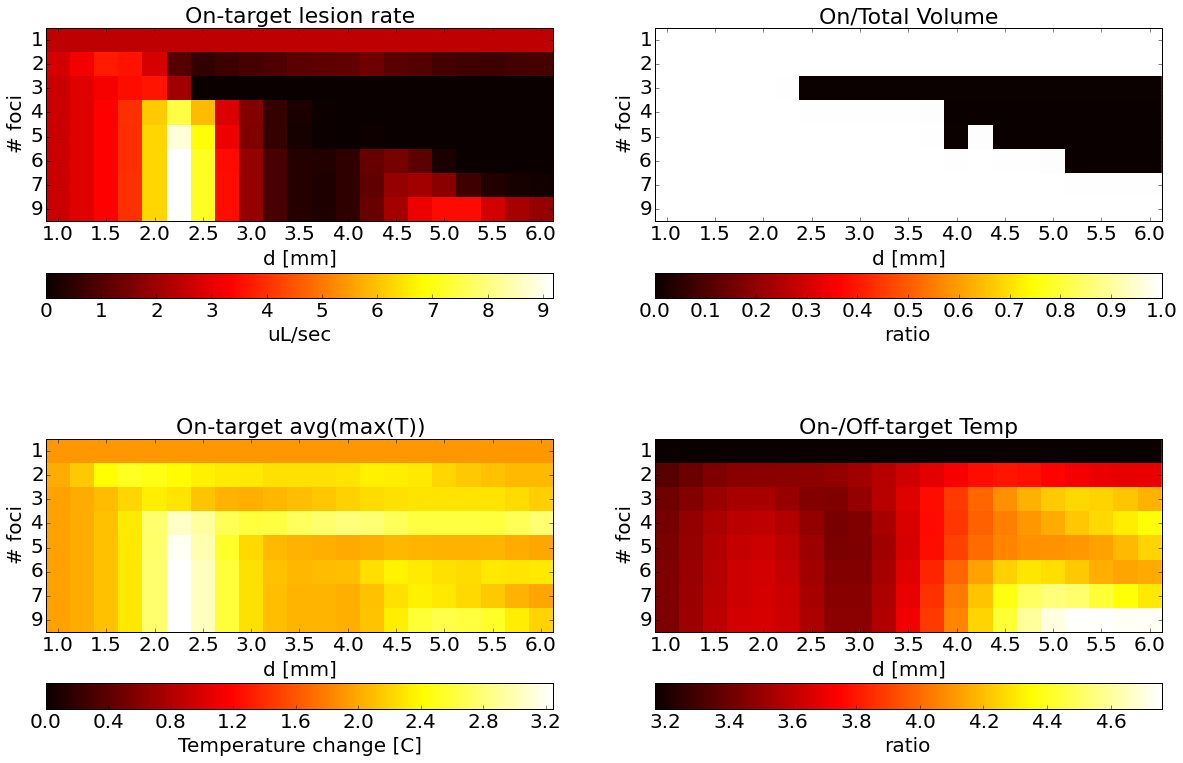

In [9]:
#lesionRatesEXTRA - lesionRatesON


zeroMask=lesionRatesEXTRA==0

onExtraVolratio = lesionRatesON/lesionRatesEXTRA
onExtraVolratio[zeroMask]=0

plt.figure(figsize=(20,13.5))

cmm=image.cm.hot

ax=plt.subplot(221)
maxmlRate=np.max(lesionRatesAllSpace)
plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
dSpc = (diamList[-1] - diamList[-2])
#bounds = [ 1000*(diamList[0] + dSpc/2), 1000*(diamList[-1] + dSpc/2 + dSpc ) , nfociList[-1]+1, nfociList[0] ]
plt.imshow( lesionRatesON*1000 , vmin=0,vmax=maxmlRate*1000, interpolation='None',cmap=cmm )

ax.set_title("On-target lesion rate",fontsize=22)

dstep=2
diamStr = list(map(lambda d:"%0.1f" % d,1000*diamList[0:ndtrials:dstep]))
diamLocs= np.arange(0.0, ndtrials,dstep)

cb=plt.colorbar(orientation='horizontal')
cb.set_label('uL/sec',fontsize=20)
cb.ax.tick_params(labelsize=20)

ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )
ax.tick_params(labelsize=20)



ax=plt.subplot(222)
ax.set_title("On/Total Volume",fontsize=22)

ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )

plt.imshow( onExtraVolratio,interpolation='None',cmap=cmm )

cb=plt.colorbar(orientation='horizontal')
cb.set_label('ratio',fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)



ax=plt.subplot(223)
ax.set_title("On-target avg(max(T))",fontsize=22)
ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )

plt.imshow( TavgRatesON,vmin=0,interpolation='None',cmap=cmm )
plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)

cb=plt.colorbar(orientation='horizontal')
cb.set_label('Temperature change [C]',fontsize=20)
cb.ax.tick_params(labelsize=20)



ax=plt.subplot(224)

ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )
ax.set_title("On-/Off-target Temp",fontsize=22)
#plt.imshow( (TavgRatesON-T0) / (TavgRatesOFF-T0),interpolation='None',cmap=cmm )
plt.imshow( (TavgRatesON/TavgRatesOFF) ,interpolation='None',cmap=cmm )
cb=plt.colorbar(orientation='horizontal')
cb.set_label('ratio',fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)


In [106]:
c0/f0

0.0012833333333333334

In [82]:
(TavgRatesON)

array([[ 5.55517578,  5.55517578,  5.55517578,  5.55517578,  5.55517578,
         5.55517578,  5.55517578,  5.55517578,  5.55517578,  5.55517578,
         5.55517578],
       [ 5.83449173,  6.99565887,  7.19672012,  6.78125763,  6.68323135,
         6.57369232,  6.60638046,  6.73049927,  6.42687607,  6.11297226,
         6.00884628],
       [ 5.68872452,  6.06356049,  6.75259018,  6.1681366 ,  5.89303207,
         6.10832596,  6.36491394,  6.58233261,  6.59631729,  6.60444641,
         6.28596497],
       [ 5.69009399,  6.11384201,  7.98418427,  8.4628334 ,  7.57170486,
         7.89701843,  8.16650772,  7.8256073 ,  7.59607315,  7.56874084,
         8.03178024],
       [ 5.69003296,  6.11150742,  7.9623642 ,  8.61693573,  6.48841858,
         5.9181633 ,  5.80373001,  6.00746918,  5.92285156,  5.94327927,
         5.77268982],
       [ 5.69004059,  6.11157227,  7.98265839,  8.77688217,  6.60531235,
         6.01967239,  6.10076523,  6.83001328,  6.57300949,  6.6860199 ,
         6.670

In [186]:
lesionRatesON[3,3]

1132.0

In [13]:
PBHE_CUDA.Create_Global_GPU_Session32(*T4d.shape)

T4d[0][:] = T0
CEMfinal[:] = 0
Tmax[:] = 0

(duration,Tmax, ROION, ROIOFF, ROIEXTRA) = execute_sim(1,0.00225,sonication_time=10,Tmax=Tmax)

PBHE_CUDA.ResetGPU()

In [192]:
np.sum(CEMfinal[ROION]>=240.0)

1132

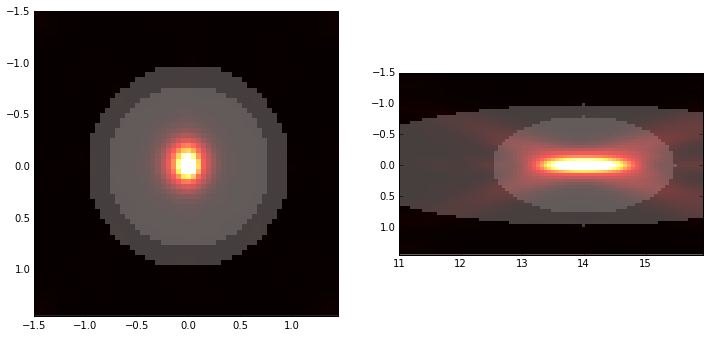

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(121)
xy=list(map( lambda x: 100*x,[yrp[0],yrp[-1],xrp[-1],xrp[0]]))
plt.imshow( Tmax[:,:,focplaneZpix] , extent=xy, vmin=37,vmax=60,cmap=image.cm.hot, interpolation='none')
plt.imshow( ROION[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')
plt.subplot(122)
yz=list(map( lambda x: 100*x,[zrp[0],zrp[-1],yrp[-1],yrp[0]]))
i=floor(Nx/2)
plt.imshow( Tmax[i,:,:] , extent=yz, vmin=37,vmax=60,cmap=image.cm.hot, interpolation='none')
plt.imshow( ROION[i,:,:] , extent=yz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[i,:,:] , extent=yz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')

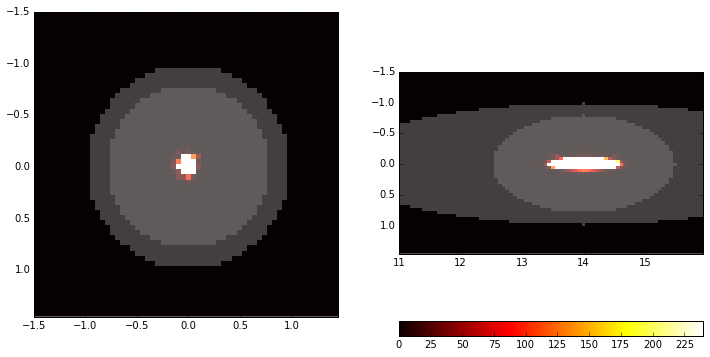

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(121)
xy=list(map( lambda x: 100*x,[yrp[0],yrp[-1],xrp[-1],xrp[0]]))
plt.imshow( CEMfinal[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=240,cmap=image.cm.hot, interpolation='none')
plt.imshow( ROION[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')
plt.subplot(122)
xz=list(map( lambda x: 100*x,[zrp[0],zrp[-1],xrp[-1],xrp[0]]))
j=floor(Ny/2)
plt.imshow( CEMfinal[:,j,:] , extent=xz, vmin=0,vmax=240,cmap=image.cm.hot, interpolation='none')
plt.colorbar(orientation='horizontal')
plt.imshow( ROION[:,j,:] , extent=xz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,j,:] , extent=xz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')


In [389]:
u,nnn=transducers.new_stipled_spherecap_array(10, 2, 9)
np.sqrt(np.sum( u**2,axis=1))

array([ 0.       ,  1.0012555,  1.0012555,  1.0012555,  1.0012555,
        1.0012555,  1.0012555,  1.0012555])

In [390]:
u

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.05012563],
       [ 0.6234898 ,  0.78183148,  0.05012563],
       [-0.22252093,  0.97492791,  0.05012563],
       [-0.90096887,  0.43388374,  0.05012563],
       [-0.90096887, -0.43388374,  0.05012563],
       [-0.22252093, -0.97492791,  0.05012563],
       [ 0.6234898 , -0.78183148,  0.05012563]])

In [204]:
qq=np.array([1,2,3])

In [208]:
type(qq)==np.ndarray

True

In [54]:
ablation_utils.countSonications(10, 4.0, 0.0, 0.6, 2.0, 4.0)

41.0

In [453]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [253]:
(un_r, un_theta, un_phi) = geom.cart2sphere(u[:,0], u[:,1], u[:,2])

In [304]:
Rn = geom.getRotZYZarray(0.05, pi, 0)

In [305]:
v = u.dot(Rn)

In [458]:
(vxyz,ns,(arr1,arr2))=transducers.subsample_transducer_array(uxyz, 0.0033,21,unormvecs=unvecs,ROC=0.14, arrays_to_grow=[uamp0,unvecs])

In [55]:
ablation_utils.countSonications(10,4,0,0.7,2.0,2.0)

36.0

In [429]:
tuple(list(uxyz.shape))

(256, 3)

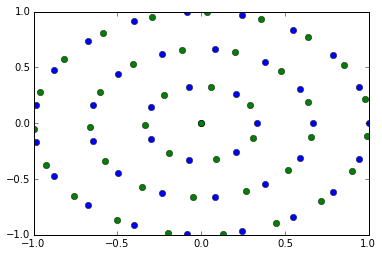

In [306]:
plt.plot(u[:,0], u[:,1],'o')
plt.plot(v[:,0], v[:,1],'o')

In [248]:
from mpl_toolkits.mplot3d import Axes3D

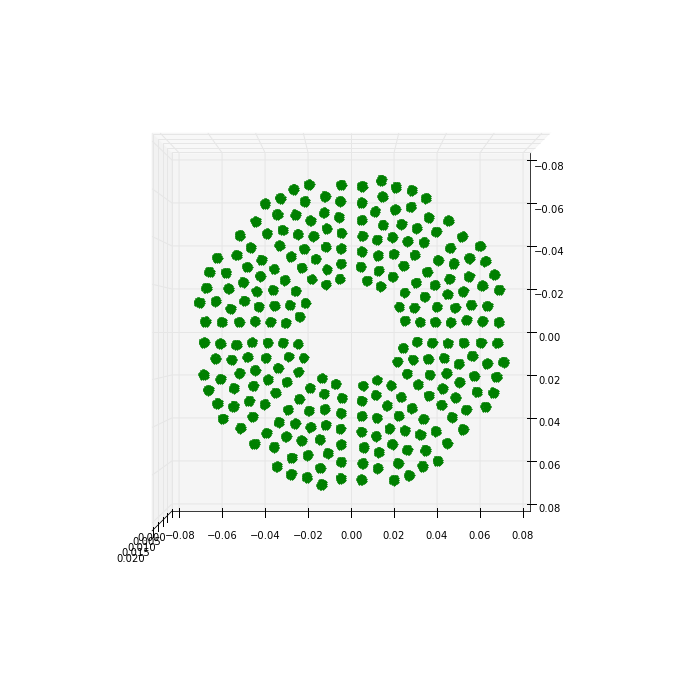

In [363]:
fig = plt.figure(figsize=(12,12), dpi=72)
ax = fig.gca(projection='3d')
ax.set_zlim(top=0.02)
ax.plot3D(uxyz[:,0], uxyz[:,1], uxyz[:,2],'.')
ax.plot3D(vxyz[:,0], vxyz[:,1], vxyz[:,2],'.')
ax.view_init(90,0)

In [1]:
import numpy as np
import sys
from math import *

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import image

%matplotlib inline

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')

import geom
import transducers
import sonalleve
import RSgpuPySwig

import PBHE_CUDA
import sys
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import importlib

In [23]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [45]:
xpp = np.arange(-0.01,0.01,0.0001)
#xpp=np.array([0.0])
#xpp=[0.0]
ypp = xpp
ypp=[0.0]
zpp = np.arange(0.07,0.16,0.0001)
#zpp=[0.14]
f0=1.2e6
c0=1540
k0=2*pi*f0/c0
rho=1000
uxyz = sonalleve.get_sonalleve_xdc_vecs()
N = uxyz.shape[0]

unvecs = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)), 1, [0.0,0.0,0.14] - uxyz )



In [27]:
len(xpp)*len(zpp)*len(ypp)

40000

In [12]:
zpp[700]

0.14000000000000201

In [50]:
#pxyz,radius = geom.ring(d,M,z=0.14)
pxyz=[[-0.002, 0.0, 0.14], [0.002, 0.0, 0.14]]
M=len(pxyz)
uamp = transducers.get_focused_element_vals( k0,uxyz,pxyz, np.ones(M), L1renorm=1.0e4 )

uamp0 = np.ones(256)

Pse = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xpp, ypp, zpp, gpublocks=64)
Ise = np.abs(Pse)**2 / (2.0*rho*c0)

Pss = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xpp, ypp, zpp, subsampN=20, subsampDiam=0.0033, ROC=0.14, gpublocks=64)
Iss = np.abs(Pss)**2 / (2.0*rho*c0)

#Ise /= np.max(Ise)
#Iss /= np.max(Iss)


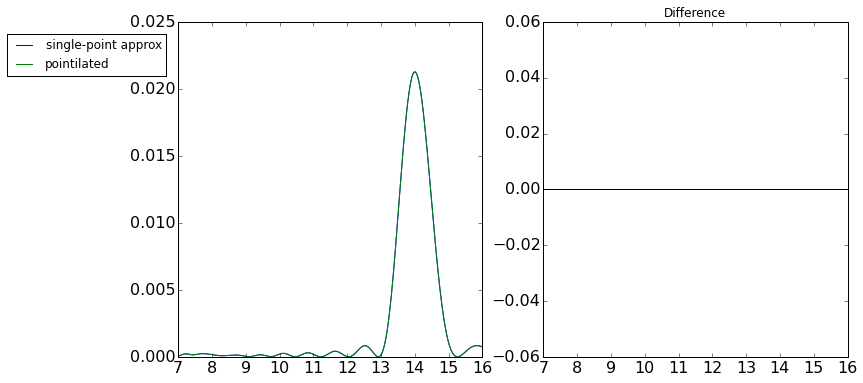

In [52]:
plt.figure(figsize=(12,6))
i=floor(len(xpp)/2)
j=floor(len(ypp)/2)
k=floor(len(zpp)/2)
plt.subplot(121)
ax=plt.gca()
ax.tick_params(labelsize=16)
plt.plot(100*zpp,Ise[i,j,:])
plt.plot(100*zpp,Iss[i,j,:])
plt.legend(['single-point approx', 'pointilated'], bbox_to_anchor=(0.0, 1), borderaxespad=1.)
plt.subplot(122)
plt.plot(100*zpp,Ise[i,0,:] - Iss[i,0,:],'k-')
ax=plt.gca()
ax.tick_params(labelsize=16)
ax.set_title('Difference')

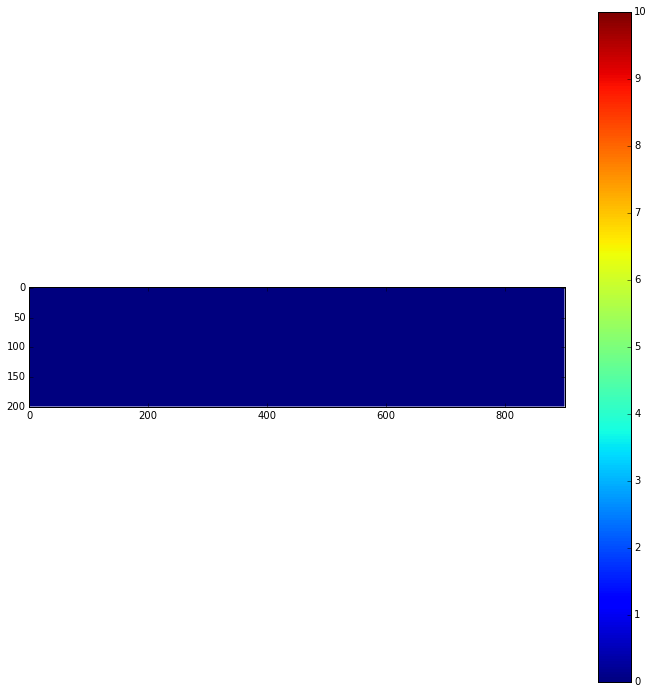

In [51]:
plt.figure(figsize=(12,12))
plt.imshow((Ise[:,0,:] - Iss[:,0,:]) /  (Iss[:,0,:]) ,vmax=10, interpolation='none' )
plt.colorbar()

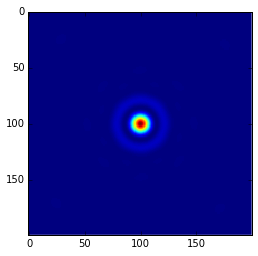

In [36]:
plt.imshow(Iss[:,:,k] , interpolation='none' )

In [12]:
path=np.array([xpp,np.zeros_like(xpp),np.ones_like(xpp)*0.14]).transpose()
Pcpu = transducers.calc_pressure_profile(k0, uxyz, uamp, path)
Icpu = np.abs(Pcpu)**2 / (2.0*rho*c0)

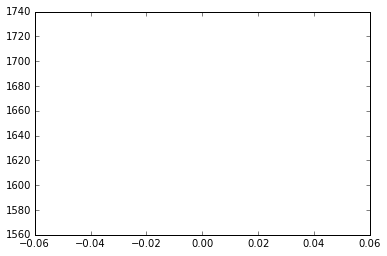

In [13]:
plt.plot(Icpu)

In [39]:
nnn=30
testarr=np.arange(0,nnn)
(uxyz,ns,(testarrnew,))=transducers.subsample_transducer_array( uxyz[0:nnn,:], 0.0033, 10,arrays_to_grow=[testarr] )

In [34]:
testarrnew

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5])

In [35]:
ns

8

In [40]:
sum(testarr)

435

In [41]:
sum(testarrnew)/ns

435.0

In [16]:
import timeit

In [17]:
def ver1():
    transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, gpublocks=0)
    
def ver2():
    transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, gpublocks=256, subsampN=20, subsampDiam=0.0033,ROC=0.14)

In [18]:
timeit.timeit( ver2,number=1)

7.227584454457917

In [ ]:
timeit.timeit( ver2,number=1)

In [42]:
256*Nx*Ny*Nz / 2251

32753.44291426033

In [44]:
16535*2

33070

In [57]:
10240*Nx*Ny*Nz / 33070

NameError: name 'Nx' is not defined

In [51]:
2251/40

56.275

NameError: name 'T' is not defined

In [60]:
q=np.zeros([2,3])

In [61]:
q.ndim

2

In [62]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()

In [64]:
uxyz.ndim

2

In [68]:
1 %1

0

In [87]:
def innerf(a=0,b=0):
    print(a,b)

def outer(x,**kwas):
    print (kwas['a'])
    innerf(**kwas)

1 0


In [88]:
outer(1,a=4)

4
4 0


In [92]:
np.zeros(2,dtype=bool)

array([False, False], dtype=bool)

In [93]:
10%1

0